# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import keras
import numpy as np
import torch
import torch.nn as nn

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.
print(builder.info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# print(mnist_test)

# Build CNN teacher.
def build_cnn():
  cnn_model = Sequential()
  cnn_model.add(Input((28,28,1)))
  cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), strides= (1,1), activation='relu'))
  cnn_model.add(MaxPooling2D(pool_size=(2,2), strides= (1,1)))
  cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), strides= (1,1), activation='relu'))
  cnn_model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
  cnn_model.add(Flatten())
  cnn_model.add(Dropout(rate=0.5))
  cnn_model.add(Dense(units=128, activation='relu'))
  cnn_model.add(Dropout(rate=0.5))
  cnn_model.add(Dense(NUM_CLASSES, activation='softmax'))
  return cnn_model

cnn_model=build_cnn()
print("\n\n\n============ Teacher Model ============\n")
cnn_model.summary()

# Build fully connected student.
def build_fc():
  fc_model = Sequential()
  fc_model.add(Input((28,28,1)))
  fc_model.add(Flatten())
  fc_model.add(Dense(units=784,activation='relu'))
  fc_model.add(Dense(units=784,activation='relu'))
  fc_model.add(Dense(NUM_CLASSES, activation='softmax'))
  return fc_model
fc_model=build_fc()
print("\n\n\n============ Student Model ============\n")
fc_model.summary()




============ Teacher Model ============

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dr

# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)
  # print(subclass_logits.shape)
  # print(tf.argmax(labels, 1).shape)
  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=subclass_logits, labels=tf.argmax(labels, 1))


  return cross_entropy_loss_value

# Student loss function

In [ ]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. # temperature hyperparameter
import numpy as np
import torch
import torch.nn as nn
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
  # print(tf.reduce_sum(tf.exp(teacher_logits/temperature),axis=1,keepdims=True).shape)
  soft_targets = tf.exp((teacher_logits-np.max(teacher_logits,axis=-1,keepdims=True))/temperature)/tf.reduce_sum(tf.exp(np.max(teacher_logits,axis=-1,keepdims=True)/temperature),axis=1,keepdims=True)

  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)
  L_hard=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=student_subclass_logits, labels=tf.argmax(labels, 1))
  # print(labels)
  # Compute cross-entropy loss with hard targets.

  cross_entropy_loss_value = ALPHA*distillation_loss_value+(1-ALPHA)*L_hard

  return cross_entropy_loss_value

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  res=0.0
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value,model.variables)
      optimizer.apply_gradients(zip(grads, model.variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      num_correct += tf.cast(compute_num_correct(model,images,labels)[0],tf.int32)
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    res=num_correct / num_total * 100
  return res


# Training models

In [ ]:
# your code start from here for step 5 

train_and_evaluate(cnn_model,compute_teacher_loss)

Epoch 1: Class_accuracy: 96.72%
Epoch 2: Class_accuracy: 97.74%
Epoch 3: Class_accuracy: 98.19%
Epoch 4: Class_accuracy: 98.49%
Epoch 5: Class_accuracy: 98.70%
Epoch 6: Class_accuracy: 98.63%
Epoch 7: Class_accuracy: 98.75%
Epoch 8: Class_accuracy: 98.73%
Epoch 9: Class_accuracy: 98.87%
Epoch 10: Class_accuracy: 98.90%
Epoch 11: Class_accuracy: 98.79%
Epoch 12: Class_accuracy: 98.92%


<tf.Tensor: shape=(), dtype=float64, numpy=98.92>

In [ ]:
cnn_model.save('teacher_MNIST.h5')

In [ ]:
T=[1,2,4,16,32,64]
A=[0.1,0.3,0.5,0.7,0.9]
y=[]
for i in T:
  for j in A:
    DISTILLATION_TEMPERATURE = i # Temperature hyperparameter
    ALPHA=j
    fc_model=build_fc()
    print('temperature:'+str(i)+' Alpha:'+str(j))
    acu=train_and_evaluate(fc_model,compute_student_loss)
    fc_model.save('student_MNIST_t'+str(i)+'a'+str(j)+'.h5')
    y.append(acu)
# train_and_evaluate(fc_model,compute_student_loss)

temperature:1 Alpha:0.1
Epoch 1: Class_accuracy: 94.30%
Epoch 2: Class_accuracy: 96.55%
Epoch 3: Class_accuracy: 96.65%
Epoch 4: Class_accuracy: 97.13%
Epoch 5: Class_accuracy: 97.53%
Epoch 6: Class_accuracy: 97.83%
Epoch 7: Class_accuracy: 97.06%
Epoch 8: Class_accuracy: 97.65%
Epoch 9: Class_accuracy: 97.59%
Epoch 10: Class_accuracy: 97.92%
Epoch 11: Class_accuracy: 97.37%
Epoch 12: Class_accuracy: 97.35%


temperature:1 Alpha:0.3
Epoch 1: Class_accuracy: 94.92%
Epoch 2: Class_accuracy: 96.88%
Epoch 3: Class_accuracy: 96.85%
Epoch 4: Class_accuracy: 97.09%
Epoch 5: Class_accuracy: 97.29%
Epoch 6: Class_accuracy: 97.61%
Epoch 7: Class_accuracy: 97.82%
Epoch 8: Class_accuracy: 97.64%
Epoch 9: Class_accuracy: 97.63%
Epoch 10: Class_accuracy: 97.94%
Epoch 11: Class_accuracy: 97.83%
Epoch 12: Class_accuracy: 97.93%


temperature:1 Alpha:0.5
Epoch 1: Class_accuracy: 95.07%
Epoch 2: Class_accuracy: 96.75%
Epoch 3: Class_accuracy: 97.35%
Epoch 4: Class_accuracy: 97.54%
Epoch 5: Class_accuracy: 97.51%
Epoch 6: Class_accuracy: 97.51%
Epoch 7: Class_accuracy: 97.81%
Epoch 8: Class_accuracy: 97.74%
Epoch 9: Class_accuracy: 97.55%
Epoch 10: Class_accuracy: 97.73%
Epoch 11: Class_accuracy: 97.80%
Epoch 12: Class_accuracy: 97.71%


temperature:1 Alpha:0.7
Epoch 1: Class_accuracy: 95.48%
Epoch 2: Class_accuracy: 96.49%
Epoch 3: Class_accuracy: 97.08%
Epoch 4: Class_accuracy: 97.41%
Epoch 5: Class_accuracy: 97.38%
Epoch 6: Class_accuracy: 97.06%
Epoch 7: Class_accuracy: 97.69%
Epoch 8: Class_accuracy: 97.66%
Epoch 9: Class_accuracy: 97.95%
Epoch 10: Class_accuracy: 97.54%
Epoch 11: Class_accuracy: 97.78%
Epoch 12: Class_accuracy: 97.30%


temperature:1 Alpha:0.9
Epoch 1: Class_accuracy: 95.28%
Epoch 2: Class_accuracy: 96.79%
Epoch 3: Class_accuracy: 97.30%
Epoch 4: Class_accuracy: 97.47%
Epoch 5: Class_accuracy: 97.78%
Epoch 6: Class_accuracy: 97.52%
Epoch 7: Class_accuracy: 97.59%
Epoch 8: Class_accuracy: 97.43%
Epoch 9: Class_accuracy: 97.50%
Epoch 10: Class_accuracy: 97.71%
Epoch 11: Class_accuracy: 97.97%
Epoch 12: Class_accuracy: 97.65%


temperature:2 Alpha:0.1
Epoch 1: Class_accuracy: 95.46%
Epoch 2: Class_accuracy: 96.58%
Epoch 3: Class_accuracy: 96.78%
Epoch 4: Class_accuracy: 97.31%
Epoch 5: Class_accuracy: 97.27%
Epoch 6: Class_accuracy: 97.56%
Epoch 7: Class_accuracy: 97.82%
Epoch 8: Class_accuracy: 97.51%
Epoch 9: Class_accuracy: 97.82%
Epoch 10: Class_accuracy: 98.11%
Epoch 11: Class_accuracy: 97.73%
Epoch 12: Class_accuracy: 97.76%


temperature:2 Alpha:0.3
Epoch 1: Class_accuracy: 95.38%
Epoch 2: Class_accuracy: 96.32%
Epoch 3: Class_accuracy: 96.98%
Epoch 4: Class_accuracy: 97.04%
Epoch 5: Class_accuracy: 97.33%
Epoch 6: Class_accuracy: 97.42%
Epoch 7: Class_accuracy: 97.65%
Epoch 8: Class_accuracy: 97.66%
Epoch 9: Class_accuracy: 97.78%
Epoch 10: Class_accuracy: 97.66%
Epoch 11: Class_accuracy: 97.83%
Epoch 12: Class_accuracy: 97.84%


temperature:2 Alpha:0.5
Epoch 1: Class_accuracy: 95.49%
Epoch 2: Class_accuracy: 96.58%
Epoch 3: Class_accuracy: 96.88%
Epoch 4: Class_accuracy: 97.19%
Epoch 5: Class_accuracy: 97.41%
Epoch 6: Class_accuracy: 97.63%
Epoch 7: Class_accuracy: 97.75%
Epoch 8: Class_accuracy: 97.41%
Epoch 9: Class_accuracy: 97.70%
Epoch 10: Class_accuracy: 97.77%
Epoch 11: Class_accuracy: 97.71%
Epoch 12: Class_accuracy: 97.61%


temperature:2 Alpha:0.7
Epoch 1: Class_accuracy: 95.18%
Epoch 2: Class_accuracy: 96.58%
Epoch 3: Class_accuracy: 97.15%
Epoch 4: Class_accuracy: 97.43%
Epoch 5: Class_accuracy: 97.35%
Epoch 6: Class_accuracy: 97.24%
Epoch 7: Class_accuracy: 97.49%
Epoch 8: Class_accuracy: 97.68%
Epoch 9: Class_accuracy: 97.50%
Epoch 10: Class_accuracy: 97.89%
Epoch 11: Class_accuracy: 97.81%
Epoch 12: Class_accuracy: 97.86%


temperature:2 Alpha:0.9
Epoch 1: Class_accuracy: 95.17%
Epoch 2: Class_accuracy: 96.56%
Epoch 3: Class_accuracy: 97.15%
Epoch 4: Class_accuracy: 97.36%
Epoch 5: Class_accuracy: 97.47%
Epoch 6: Class_accuracy: 97.25%
Epoch 7: Class_accuracy: 97.36%
Epoch 8: Class_accuracy: 97.53%
Epoch 9: Class_accuracy: 97.41%
Epoch 10: Class_accuracy: 97.79%
Epoch 11: Class_accuracy: 97.82%
Epoch 12: Class_accuracy: 97.76%


temperature:4 Alpha:0.1
Epoch 1: Class_accuracy: 95.22%
Epoch 2: Class_accuracy: 96.22%
Epoch 3: Class_accuracy: 97.03%
Epoch 4: Class_accuracy: 96.85%
Epoch 5: Class_accuracy: 97.09%
Epoch 6: Class_accuracy: 97.47%
Epoch 7: Class_accuracy: 97.39%
Epoch 8: Class_accuracy: 97.49%
Epoch 9: Class_accuracy: 97.81%
Epoch 10: Class_accuracy: 97.75%
Epoch 11: Class_accuracy: 98.00%
Epoch 12: Class_accuracy: 97.62%


temperature:4 Alpha:0.3
Epoch 1: Class_accuracy: 95.19%
Epoch 2: Class_accuracy: 96.46%
Epoch 3: Class_accuracy: 97.29%
Epoch 4: Class_accuracy: 96.84%
Epoch 5: Class_accuracy: 97.44%
Epoch 6: Class_accuracy: 97.00%
Epoch 7: Class_accuracy: 97.68%
Epoch 8: Class_accuracy: 97.70%
Epoch 9: Class_accuracy: 97.55%
Epoch 10: Class_accuracy: 97.96%
Epoch 11: Class_accuracy: 97.87%
Epoch 12: Class_accuracy: 97.94%


temperature:4 Alpha:0.5
Epoch 1: Class_accuracy: 95.41%
Epoch 2: Class_accuracy: 96.23%
Epoch 3: Class_accuracy: 96.77%
Epoch 4: Class_accuracy: 97.14%
Epoch 5: Class_accuracy: 97.40%
Epoch 6: Class_accuracy: 97.63%
Epoch 7: Class_accuracy: 97.04%
Epoch 8: Class_accuracy: 97.85%
Epoch 9: Class_accuracy: 97.77%
Epoch 10: Class_accuracy: 97.76%
Epoch 11: Class_accuracy: 97.50%
Epoch 12: Class_accuracy: 97.39%


temperature:4 Alpha:0.7
Epoch 1: Class_accuracy: 95.06%
Epoch 2: Class_accuracy: 96.30%
Epoch 3: Class_accuracy: 96.85%
Epoch 4: Class_accuracy: 97.16%
Epoch 5: Class_accuracy: 97.63%
Epoch 6: Class_accuracy: 97.41%
Epoch 7: Class_accuracy: 97.19%
Epoch 8: Class_accuracy: 97.68%
Epoch 9: Class_accuracy: 97.69%
Epoch 10: Class_accuracy: 97.70%
Epoch 11: Class_accuracy: 97.67%
Epoch 12: Class_accuracy: 97.42%


temperature:4 Alpha:0.9
Epoch 1: Class_accuracy: 94.90%
Epoch 2: Class_accuracy: 95.72%
Epoch 3: Class_accuracy: 96.95%
Epoch 4: Class_accuracy: 97.29%
Epoch 5: Class_accuracy: 97.32%
Epoch 6: Class_accuracy: 97.61%
Epoch 7: Class_accuracy: 97.07%
Epoch 8: Class_accuracy: 97.62%
Epoch 9: Class_accuracy: 97.45%
Epoch 10: Class_accuracy: 97.25%
Epoch 11: Class_accuracy: 97.64%
Epoch 12: Class_accuracy: 97.67%


temperature:16 Alpha:0.1
Epoch 1: Class_accuracy: 95.03%
Epoch 2: Class_accuracy: 96.68%
Epoch 3: Class_accuracy: 96.29%
Epoch 4: Class_accuracy: 97.47%
Epoch 5: Class_accuracy: 97.35%
Epoch 6: Class_accuracy: 97.58%
Epoch 7: Class_accuracy: 97.46%
Epoch 8: Class_accuracy: 97.68%
Epoch 9: Class_accuracy: 97.67%
Epoch 10: Class_accuracy: 97.76%
Epoch 11: Class_accuracy: 97.76%
Epoch 12: Class_accuracy: 97.52%


temperature:16 Alpha:0.3
Epoch 1: Class_accuracy: 94.79%
Epoch 2: Class_accuracy: 96.21%
Epoch 3: Class_accuracy: 96.72%
Epoch 4: Class_accuracy: 97.03%
Epoch 5: Class_accuracy: 96.98%
Epoch 6: Class_accuracy: 97.25%
Epoch 7: Class_accuracy: 97.24%
Epoch 8: Class_accuracy: 97.93%
Epoch 9: Class_accuracy: 97.63%
Epoch 10: Class_accuracy: 97.74%
Epoch 11: Class_accuracy: 97.83%
Epoch 12: Class_accuracy: 97.60%


temperature:16 Alpha:0.5
Epoch 1: Class_accuracy: 94.84%
Epoch 2: Class_accuracy: 96.14%
Epoch 3: Class_accuracy: 96.51%
Epoch 4: Class_accuracy: 97.22%
Epoch 5: Class_accuracy: 97.66%
Epoch 6: Class_accuracy: 97.23%
Epoch 7: Class_accuracy: 97.40%
Epoch 8: Class_accuracy: 97.72%
Epoch 9: Class_accuracy: 97.46%
Epoch 10: Class_accuracy: 97.91%
Epoch 11: Class_accuracy: 97.86%
Epoch 12: Class_accuracy: 97.66%


temperature:16 Alpha:0.7
Epoch 1: Class_accuracy: 95.19%
Epoch 2: Class_accuracy: 96.21%
Epoch 3: Class_accuracy: 97.00%
Epoch 4: Class_accuracy: 97.22%
Epoch 5: Class_accuracy: 97.15%
Epoch 6: Class_accuracy: 97.65%
Epoch 7: Class_accuracy: 97.64%
Epoch 8: Class_accuracy: 97.32%
Epoch 9: Class_accuracy: 97.41%
Epoch 10: Class_accuracy: 97.30%
Epoch 11: Class_accuracy: 97.78%
Epoch 12: Class_accuracy: 97.75%


temperature:16 Alpha:0.9
Epoch 1: Class_accuracy: 95.37%
Epoch 2: Class_accuracy: 96.71%
Epoch 3: Class_accuracy: 96.28%
Epoch 4: Class_accuracy: 96.97%
Epoch 5: Class_accuracy: 97.24%
Epoch 6: Class_accuracy: 97.56%
Epoch 7: Class_accuracy: 97.30%
Epoch 8: Class_accuracy: 97.75%
Epoch 9: Class_accuracy: 97.62%
Epoch 10: Class_accuracy: 97.92%
Epoch 11: Class_accuracy: 97.82%
Epoch 12: Class_accuracy: 97.78%


temperature:32 Alpha:0.1
Epoch 1: Class_accuracy: 95.07%
Epoch 2: Class_accuracy: 96.21%
Epoch 3: Class_accuracy: 97.04%
Epoch 4: Class_accuracy: 97.46%
Epoch 5: Class_accuracy: 97.30%
Epoch 6: Class_accuracy: 97.66%
Epoch 7: Class_accuracy: 97.59%
Epoch 8: Class_accuracy: 97.79%
Epoch 9: Class_accuracy: 97.78%
Epoch 10: Class_accuracy: 97.69%
Epoch 11: Class_accuracy: 97.78%
Epoch 12: Class_accuracy: 97.99%


temperature:32 Alpha:0.3
Epoch 1: Class_accuracy: 95.01%
Epoch 2: Class_accuracy: 96.57%
Epoch 3: Class_accuracy: 96.61%
Epoch 4: Class_accuracy: 97.42%
Epoch 5: Class_accuracy: 97.61%
Epoch 6: Class_accuracy: 97.45%
Epoch 7: Class_accuracy: 97.39%
Epoch 8: Class_accuracy: 97.88%
Epoch 9: Class_accuracy: 97.58%
Epoch 10: Class_accuracy: 97.70%
Epoch 11: Class_accuracy: 97.75%
Epoch 12: Class_accuracy: 97.66%


temperature:32 Alpha:0.5
Epoch 1: Class_accuracy: 95.17%
Epoch 2: Class_accuracy: 96.49%
Epoch 3: Class_accuracy: 97.00%
Epoch 4: Class_accuracy: 97.40%
Epoch 5: Class_accuracy: 97.33%
Epoch 6: Class_accuracy: 97.34%
Epoch 7: Class_accuracy: 96.84%
Epoch 8: Class_accuracy: 97.74%
Epoch 9: Class_accuracy: 97.89%
Epoch 10: Class_accuracy: 97.64%
Epoch 11: Class_accuracy: 97.91%
Epoch 12: Class_accuracy: 97.90%


temperature:32 Alpha:0.7
Epoch 1: Class_accuracy: 95.43%
Epoch 2: Class_accuracy: 96.73%
Epoch 3: Class_accuracy: 97.05%
Epoch 4: Class_accuracy: 97.57%
Epoch 5: Class_accuracy: 97.31%
Epoch 6: Class_accuracy: 97.71%
Epoch 7: Class_accuracy: 97.13%
Epoch 8: Class_accuracy: 97.44%
Epoch 9: Class_accuracy: 97.75%
Epoch 10: Class_accuracy: 97.54%
Epoch 11: Class_accuracy: 97.51%
Epoch 12: Class_accuracy: 97.90%


temperature:32 Alpha:0.9
Epoch 1: Class_accuracy: 94.98%
Epoch 2: Class_accuracy: 96.28%
Epoch 3: Class_accuracy: 97.05%
Epoch 4: Class_accuracy: 97.15%
Epoch 5: Class_accuracy: 97.34%
Epoch 6: Class_accuracy: 97.36%
Epoch 7: Class_accuracy: 97.49%
Epoch 8: Class_accuracy: 97.42%
Epoch 9: Class_accuracy: 97.64%
Epoch 10: Class_accuracy: 97.51%
Epoch 11: Class_accuracy: 97.19%
Epoch 12: Class_accuracy: 97.41%


temperature:64 Alpha:0.1
Epoch 1: Class_accuracy: 95.13%
Epoch 2: Class_accuracy: 96.31%
Epoch 3: Class_accuracy: 96.43%
Epoch 4: Class_accuracy: 96.88%
Epoch 5: Class_accuracy: 97.39%
Epoch 6: Class_accuracy: 97.49%
Epoch 7: Class_accuracy: 97.52%
Epoch 8: Class_accuracy: 97.54%
Epoch 9: Class_accuracy: 97.47%
Epoch 10: Class_accuracy: 97.86%
Epoch 11: Class_accuracy: 97.34%
Epoch 12: Class_accuracy: 97.86%


temperature:64 Alpha:0.3
Epoch 1: Class_accuracy: 95.28%
Epoch 2: Class_accuracy: 96.84%
Epoch 3: Class_accuracy: 96.75%
Epoch 4: Class_accuracy: 97.29%
Epoch 5: Class_accuracy: 97.18%
Epoch 6: Class_accuracy: 97.45%
Epoch 7: Class_accuracy: 97.63%
Epoch 8: Class_accuracy: 97.40%
Epoch 9: Class_accuracy: 98.08%
Epoch 10: Class_accuracy: 97.72%
Epoch 11: Class_accuracy: 96.96%
Epoch 12: Class_accuracy: 97.44%


temperature:64 Alpha:0.5
Epoch 1: Class_accuracy: 94.55%
Epoch 2: Class_accuracy: 96.30%
Epoch 3: Class_accuracy: 96.78%
Epoch 4: Class_accuracy: 96.60%
Epoch 5: Class_accuracy: 97.50%
Epoch 6: Class_accuracy: 97.53%
Epoch 7: Class_accuracy: 97.51%
Epoch 8: Class_accuracy: 97.68%
Epoch 9: Class_accuracy: 97.67%
Epoch 10: Class_accuracy: 97.89%
Epoch 11: Class_accuracy: 97.92%
Epoch 12: Class_accuracy: 97.39%


temperature:64 Alpha:0.7
Epoch 1: Class_accuracy: 95.35%
Epoch 2: Class_accuracy: 96.03%
Epoch 3: Class_accuracy: 96.85%
Epoch 4: Class_accuracy: 97.41%
Epoch 5: Class_accuracy: 97.10%
Epoch 6: Class_accuracy: 97.22%
Epoch 7: Class_accuracy: 97.60%
Epoch 8: Class_accuracy: 97.59%
Epoch 9: Class_accuracy: 97.65%
Epoch 10: Class_accuracy: 97.71%
Epoch 11: Class_accuracy: 97.60%
Epoch 12: Class_accuracy: 97.85%


temperature:64 Alpha:0.9
Epoch 1: Class_accuracy: 95.08%
Epoch 2: Class_accuracy: 96.68%
Epoch 3: Class_accuracy: 96.61%
Epoch 4: Class_accuracy: 97.09%
Epoch 5: Class_accuracy: 97.42%
Epoch 6: Class_accuracy: 97.42%
Epoch 7: Class_accuracy: 97.50%
Epoch 8: Class_accuracy: 97.38%
Epoch 9: Class_accuracy: 97.41%
Epoch 10: Class_accuracy: 97.64%
Epoch 11: Class_accuracy: 97.44%
Epoch 12: Class_accuracy: 97.59%


In [ ]:
# fc_model.save('student_MNIST_4.h5')
for i in range(6):
  for j in range(5):
    print('Temperature:'+str(T[i])+' Alpha:'+str(A[j])+' Accuracy:'+str(y[i*5+j]))

Temperature:1 Alpha:0.1 Accuracy:tf.Tensor(97.35000000000001, shape=(), dtype=float64)
Temperature:1 Alpha:0.3 Accuracy:tf.Tensor(97.92999999999999, shape=(), dtype=float64)
Temperature:1 Alpha:0.5 Accuracy:tf.Tensor(97.71, shape=(), dtype=float64)
Temperature:1 Alpha:0.7 Accuracy:tf.Tensor(97.3, shape=(), dtype=float64)
Temperature:1 Alpha:0.9 Accuracy:tf.Tensor(97.65, shape=(), dtype=float64)
Temperature:2 Alpha:0.1 Accuracy:tf.Tensor(97.76, shape=(), dtype=float64)
Temperature:2 Alpha:0.3 Accuracy:tf.Tensor(97.84, shape=(), dtype=float64)
Temperature:2 Alpha:0.5 Accuracy:tf.Tensor(97.61, shape=(), dtype=float64)
Temperature:2 Alpha:0.7 Accuracy:tf.Tensor(97.86, shape=(), dtype=float64)
Temperature:2 Alpha:0.9 Accuracy:tf.Tensor(97.76, shape=(), dtype=float64)
Temperature:4 Alpha:0.1 Accuracy:tf.Tensor(97.61999999999999, shape=(), dtype=float64)
Temperature:4 Alpha:0.3 Accuracy:tf.Tensor(97.94, shape=(), dtype=float64)
Temperature:4 Alpha:0.5 Accuracy:tf.Tensor(97.39, shape=(), dtype

# Test accuracy vs. tempreture curve

In [ ]:
ALPHA=0.5
T=[1,2,4,16,32,64]
y=[]
for i in T:
  DISTILLATION_TEMPERATURE = i # Temperature hyperparameter
  fc_model=build_fc()
  print('temperature:'+str(i))
  acu=train_and_evaluate(fc_model,compute_student_loss)
  fc_model.save('student_MNIST_'+str(i)+'.h5')
  y.append(acu)

temperature:1
Epoch 1: Class_accuracy: 94.15%
Epoch 2: Class_accuracy: 96.51%
Epoch 3: Class_accuracy: 96.66%
Epoch 4: Class_accuracy: 97.15%
Epoch 5: Class_accuracy: 97.68%
Epoch 6: Class_accuracy: 97.70%
Epoch 7: Class_accuracy: 97.45%
Epoch 8: Class_accuracy: 97.74%
Epoch 9: Class_accuracy: 97.67%
Epoch 10: Class_accuracy: 97.87%
Epoch 11: Class_accuracy: 97.60%
Epoch 12: Class_accuracy: 98.04%


temperature:2
Epoch 1: Class_accuracy: 95.35%
Epoch 2: Class_accuracy: 96.51%
Epoch 3: Class_accuracy: 96.84%
Epoch 4: Class_accuracy: 96.90%
Epoch 5: Class_accuracy: 97.55%
Epoch 6: Class_accuracy: 97.66%
Epoch 7: Class_accuracy: 97.62%
Epoch 8: Class_accuracy: 97.22%
Epoch 9: Class_accuracy: 97.50%
Epoch 10: Class_accuracy: 97.73%
Epoch 11: Class_accuracy: 97.62%
Epoch 12: Class_accuracy: 97.70%


temperature:4
Epoch 1: Class_accuracy: 95.00%
Epoch 2: Class_accuracy: 96.49%
Epoch 3: Class_accuracy: 96.59%
Epoch 4: Class_accuracy: 96.99%
Epoch 5: Class_accuracy: 97.36%
Epoch 6: Class_accuracy: 97.30%
Epoch 7: Class_accuracy: 97.62%
Epoch 8: Class_accuracy: 97.66%
Epoch 9: Class_accuracy: 97.41%
Epoch 10: Class_accuracy: 97.53%
Epoch 11: Class_accuracy: 97.52%
Epoch 12: Class_accuracy: 97.74%


temperature:16
Epoch 1: Class_accuracy: 95.35%
Epoch 2: Class_accuracy: 96.63%
Epoch 3: Class_accuracy: 96.66%
Epoch 4: Class_accuracy: 97.42%
Epoch 5: Class_accuracy: 97.65%
Epoch 6: Class_accuracy: 97.73%
Epoch 7: Class_accuracy: 97.82%
Epoch 8: Class_accuracy: 97.83%
Epoch 9: Class_accuracy: 97.72%
Epoch 10: Class_accuracy: 97.76%
Epoch 11: Class_accuracy: 97.51%
Epoch 12: Class_accuracy: 97.60%


temperature:32
Epoch 1: Class_accuracy: 95.28%
Epoch 2: Class_accuracy: 95.77%
Epoch 3: Class_accuracy: 97.01%
Epoch 4: Class_accuracy: 97.25%
Epoch 5: Class_accuracy: 97.46%
Epoch 6: Class_accuracy: 96.98%
Epoch 7: Class_accuracy: 97.45%
Epoch 8: Class_accuracy: 97.34%
Epoch 9: Class_accuracy: 98.01%
Epoch 10: Class_accuracy: 97.89%
Epoch 11: Class_accuracy: 97.60%
Epoch 12: Class_accuracy: 97.80%


temperature:64
Epoch 1: Class_accuracy: 95.09%
Epoch 2: Class_accuracy: 96.50%
Epoch 3: Class_accuracy: 97.13%
Epoch 4: Class_accuracy: 96.78%
Epoch 5: Class_accuracy: 97.24%
Epoch 6: Class_accuracy: 97.61%
Epoch 7: Class_accuracy: 97.55%
Epoch 8: Class_accuracy: 97.22%
Epoch 9: Class_accuracy: 97.33%
Epoch 10: Class_accuracy: 97.45%
Epoch 11: Class_accuracy: 97.81%
Epoch 12: Class_accuracy: 97.73%


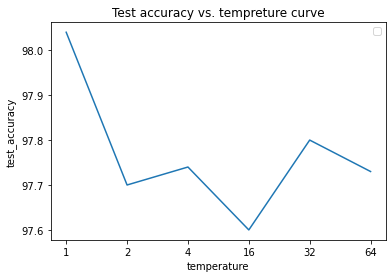

In [ ]:
import matplotlib.pyplot as plt
x=['1','2','4','16','32','64']
l=plt.plot(x,y)
plt.title('Test accuracy vs. tempreture curve')
plt.xlabel('temperature')
plt.ylabel('test_accuracy')
plt.legend()
plt.show()

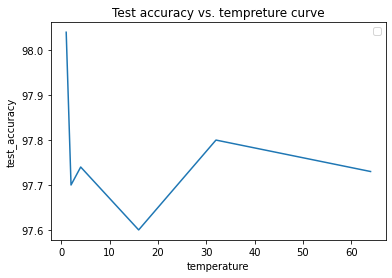

In [ ]:
import matplotlib.pyplot as plt
x=['1','2','4','16','32','64']
l=plt.plot(T,y)
plt.title('Test accuracy vs. tempreture curve')
plt.xlabel('temperature')
plt.ylabel('test_accuracy')
plt.legend()
plt.show()

# Train student from scratch

In [ ]:
# Build fully connected student.
# fc_model_no_distillation = tf.keras.Sequential()
fc_model_no_distillation = build_fc()

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7
  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=student_subclass_logits, labels=tf.argmax(labels, 1))

  
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 94.74%
Epoch 2: Class_accuracy: 96.23%
Epoch 3: Class_accuracy: 96.85%
Epoch 4: Class_accuracy: 97.13%
Epoch 5: Class_accuracy: 97.35%
Epoch 6: Class_accuracy: 97.65%
Epoch 7: Class_accuracy: 97.28%
Epoch 8: Class_accuracy: 97.59%
Epoch 9: Class_accuracy: 97.89%
Epoch 10: Class_accuracy: 97.89%
Epoch 11: Class_accuracy: 97.63%
Epoch 12: Class_accuracy: 97.71%


<tf.Tensor: shape=(), dtype=float64, numpy=97.71>

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
!pip install keras_flops

     |████████████████████████████████| 462 kB 4.2 MB/s 


In [ ]:
from keras_flops import get_flops
# flops = tf.profiler.profile(fc_model, options=tf.profiler.ProfileOptionBuilder.float_operation())
print('teacher model:')
print('Parameter number:'+str(np.sum([np.prod(vp.get_shape().as_list()) for vp in cnn_model.variables])))
print('FlOPs:'+str(get_flops(cnn_model,batch_size=BATCH_SIZE)/1000000000.0))
print('student model with KD:')
print('Parameter number:'+str(np.sum([np.prod(vp.get_shape().as_list()) for vp in fc_model.variables])))
print('FlOPs:'+str(get_flops(fc_model,batch_size=BATCH_SIZE)/1000000000.0))
print('student model without KD:')
print('Parameter number:'+str(np.sum([np.prod(vp.get_shape().as_list()) for vp in fc_model_no_distillation.variables])))
print('FlOPs:'+str(get_flops(fc_model_no_distillation,batch_size=BATCH_SIZE)/1000000000.0))
# flops = tf.profiler.experimental.Profile(cnn_model, options=tf.profiler.ProfileOptionBuilder.float_operation())
# params = tf.profiler.profile(cnn_model, options=tf.profiler.ProfileOptionBuilder.trainable_variables_parameter())
# print('student model:')
# flops = tf.profiler.profile(fc_model, options=tf.profiler.ProfileOptionBuilder.float_operation())
# params = tf.profiler.profile(fc_model, options=tf.profiler.ProfileOptionBuilder.trainable_variables_parameter())

teacher model:
Parameter number:1011466
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


FlOPs:5.642779648
student model with KD:
Parameter number:1238730
FlOPs:0.633838592
student model without KD:
Parameter number:1238730
FlOPs:0.633838592


# XAI method to explain models

In [ ]:
# your code start from here for step 9
import copy
from PIL import Image, ImageDraw

def create_random_mask(h=7,
                       w=7,
                       H=28,
                       W=28,
                       p_1=0.5,
                       resample=Image.BILINEAR):
    '''
    Generates one random mask utilized in RISE
    inputs:
        h, w: initial size of binary mask
        H, W: final size of the upsampled mask
        p_1: probability of actiating pixels in the down-sampled masks.
        interp: upsampling technique.
    returns:
        mask: a smooth mask with the values in range [0,1] with size of HxW.
    '''
    assert H > h, 'Masks should be resized to higher dimensions.'
    assert W > w, 'Masks should be resized to higher dimensions.'
    # create random binary hxw mask
    mask = np.random.choice([0, 1], size=(h, w), p=[1 - p_1, p_1])

    # upsample mask to (h+H,w+W)
    mask = Image.fromarray(mask * 255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # randomly crop mask to HxW
    w_crop = np.random.randint(0, w + 1)
    h_crop = np.random.randint(0, h + 1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize between 0 and 1
    mask /= np.max(mask)

    return mask

def RISE(img, model, class_index, N_MASKS=8000, H=28, W=28, C=1):
    '''
	img: a 3-D input image
	model: a trained model
	class_index; The class of interest
	N_MASKS: The number of random masks to be generated
	H,W,C: The desired dimensions of the random masks
	'''
    X = np.zeros(shape=(N_MASKS, H, W, C), dtype=np.float32)
    masks = np.zeros((N_MASKS, H, W), dtype=np.float32)
    for i in range(N_MASKS):
        m = create_random_mask(H=H, W=W)
        masks[i] = m
        # print(img)
        # x = img.numpy()
        x = img.copy()
        if C==1:
          x[:, :, 0] *= m
        if C==3:
          x[:, :, 0] *= m
          x[:, :, 1] *= m
          x[:, :, 2] *= m
        X[i] = x
    preds_masked = model.predict(X, verbose=0)
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    # np.einsum???
    for i, mask in enumerate(masks):
        # print(i)
        # print(mask)
        m = mask * preds_masked[i, class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    return sum_mask


In [ ]:
dataf, label = iter(mnist_train).next()
# index in range [0,255]
index = 3

In [ ]:
cnn_model.summary()
fc_model.summary()
fc_model_no_distillation.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dropout)           (None, 7744)              0

In [ ]:
print(dataf[index].shape)
_dataf = np.expand_dims(dataf[index], axis=0)
print(_dataf.shape)
print(np.expand_dims(label[index], axis=-1).shape)
print(np.expand_dims(label[index], axis=-1))
# print(_dataf.shape)
# (None,28,28,1)

(28, 28, 1)
(1, 28, 28, 1)
(10, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
# !pip install lime

In [ ]:
# import lime
# from lime import lime_image

# explainer = lime_image.LimeImageExplainer()

In [ ]:
# explaination_map_lime = explainer.explain_instance(dataf[index].astype('double'), top_labels = 10, hide_color = 0, number_samples=1000)

In [ ]:
%%time
# print(type(dataf[index]))
# d = tf.convert_to_tensor(dataf[index])
# print(type(d))

# # f = tf.Tensor(dataf[index])

# # print(type(f))

# g = dataf[index].numpy()
# print(type(g))

# print(np.argmax(label[index]))
# print(type(np.argmax(label[index])))

explanation_map_RISE_teacher = RISE(dataf[index].numpy(), cnn_model, class_index=np.argmax(label[index]) ,N_MASKS=1000)
explanation_map_RISE_teacher -= explanation_map_RISE_teacher.min()
explanation_map_RISE_teacher /= explanation_map_RISE_teacher.max()+10e-30

CPU times: user 273 ms, sys: 7.23 ms, total: 280 ms
Wall time: 284 ms


In [ ]:
explanation_map_RISE_teacher = RISE(dataf[index].numpy(), cnn_model, class_index=np.argmax(label[index]) ,N_MASKS=1000)
explanation_map_RISE_teacher -= explanation_map_RISE_teacher.min()
explanation_map_RISE_teacher /= explanation_map_RISE_teacher.max()+10e-30

In [ ]:
explanation_map_RISE_student = RISE(dataf[index].numpy(), fc_model, class_index=np.argmax(label[index]) ,N_MASKS=1000)
explanation_map_RISE_student -= explanation_map_RISE_student.min()
explanation_map_RISE_student /= explanation_map_RISE_student.max()+10e-30

In [ ]:
explanation_map_RISE_student_nokd = RISE(dataf[index].numpy(), fc_model_no_distillation, class_index=np.argmax(label[index]) ,N_MASKS=1000)
explanation_map_RISE_student_nokd -= explanation_map_RISE_student_nokd.min()
explanation_map_RISE_student_nokd /= explanation_map_RISE_student_nokd.max()+10e-30

In [ ]:
print(explanation_map_RISE_student_nokd.shape)
input = dataf[index].numpy().reshape((28,28))
print(input.shape)

(28, 28)
(28, 28)


3


Text(0.5, 1.0, 'Explanation map (Student Model without KD)')

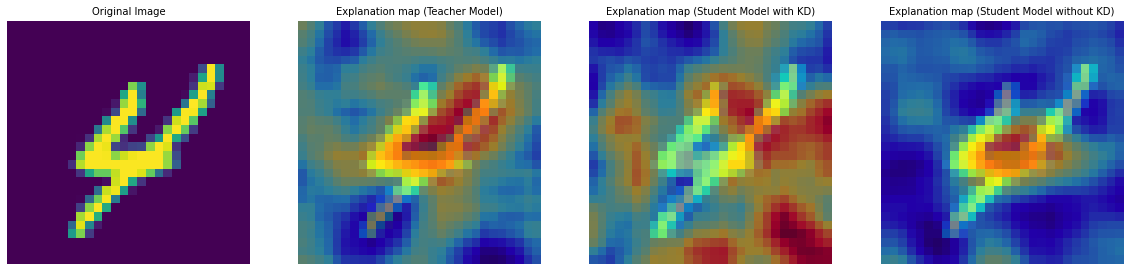

In [ ]:
plt.figure(figsize=(20,5))
print(index)

plt.subplot(1,4,1)
plt.imshow(input)
plt.axis('off')
plt.title('Original Image', fontsize=10)

plt.subplot(1,4,2)
plt.imshow(input)
plt.imshow(explanation_map_RISE_teacher, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Teacher Model)', fontsize=10)

plt.subplot(1,4,3)
plt.imshow(input)
plt.imshow(explanation_map_RISE_student, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Student Model with KD)', fontsize=10)

plt.subplot(1,4,4)
plt.imshow(input)
plt.imshow(explanation_map_RISE_student_nokd, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Student Model without KD)', fontsize=10)

# Implementing the state-of-the-art KD algorithm

In [ ]:
def train_and_evaluate_ESKD(model, compute_loss_fn,epoch_num=12):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  res=0.0
  for epoch in range(1, epoch_num + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    loss_total=0
    count_total=0
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images,labels)
      grads = tape.gradient(loss_value,model.variables)
      optimizer.apply_gradients(zip(grads, model.variables))
    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      num_correct += tf.cast(compute_num_correct(model,images,labels)[0],tf.int32)
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    res=num_correct / num_total * 100
  return res

In [ ]:
train_and_evaluate_ESKD(cnn_model,compute_teacher_loss)
train_and_evaluate(fc_model,compute_student_loss)

Epoch 1: Class_accuracy: 98.82%
Epoch 2: Class_accuracy: 98.96%
Epoch 3: Class_accuracy: 98.90%
Epoch 4: Class_accuracy: 98.91%
Epoch 5: Class_accuracy: 99.02%
Epoch 6: Class_accuracy: 98.92%
Epoch 7: Class_accuracy: 98.85%
Epoch 8: Class_accuracy: 99.12%
Epoch 9: Class_accuracy: 99.06%
Epoch 10: Class_accuracy: 99.07%
Epoch 11: Class_accuracy: 99.07%
Epoch 12: Class_accuracy: 98.99%
Epoch 1: Class_accuracy: 97.48%
Epoch 2: Class_accuracy: 97.71%
Epoch 3: Class_accuracy: 97.89%
Epoch 4: Class_accuracy: 98.05%
Epoch 5: Class_accuracy: 98.02%
Epoch 6: Class_accuracy: 97.60%
Epoch 7: Class_accuracy: 97.88%
Epoch 8: Class_accuracy: 97.55%
Epoch 9: Class_accuracy: 97.99%
Epoch 10: Class_accuracy: 97.96%
Epoch 11: Class_accuracy: 97.92%
Epoch 12: Class_accuracy: 98.08%


<tf.Tensor: shape=(), dtype=float64, numpy=98.08>

In [ ]:
T=[1,2,3,4,5,6,7,8,9,10,11,12]
y=[]
for i in T:
  # NUM_EPOCHS = 3 #temperature hyperparameter
  cnn_model=build_cnn()
  fc_model=build_fc()
  print('EpochNumber: '+str(i))
  print('Training teacher')
  @tf.function
  def compute_teacher_loss(images, labels):
    """Compute subclass knowledge distillation teacher loss for given images
      and labels.

    Args:
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Scalar loss Tensor.
    """
    subclass_logits = cnn_model(images, training=True)
    # print(subclass_logits.shape)
    # print(tf.argmax(labels, 1).shape)
    # Compute cross-entropy loss for subclasses.

    # your code start from here for step 3
    cross_entropy_loss_value = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=subclass_logits, labels=tf.argmax(labels, 1))
    return cross_entropy_loss_value
  train_and_evaluate_ESKD(cnn_model,compute_teacher_loss,i)
  # NUM_EPOCHS = 12
  print('Training student')
  acu=train_and_evaluate(fc_model,compute_student_loss)
  cnn_model.save('teacher_MNIST_ESKD_'+str(i)+'.h5')
  fc_model.save('student_MNIST_ESKD_'+str(i)+'.h5')
  y.append(acu)

In [ ]:
import matplotlib.pyplot as plt
x=T
l=plt.plot(x,y)
plt.title('Test accuracy vs. Teacher Epoch Number')
plt.xlabel('Teacher_epoch_number')
plt.ylabel('test_accuracy')
plt.legend()
plt.show()

In [ ]:
def train_and_evaluate_ESKD(model, compute_loss_fn,epoch_num=12):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  res=0.0
  for epoch in range(1, epoch_num + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    flag=False
    loss_total=0
    count_total=0
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images,labels)
      loss_total=loss_total+loss_value
      count_total=count_total+1
      grads = tape.gradient(loss_value,model.variables)
      optimizer.apply_gradients(zip(grads, model.variables))
    loss_total=loss_total/count_total
    if(loss_total<1):
      flag=True
    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      num_correct += tf.cast(compute_num_correct(model,images,labels)[0],tf.int32)
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    res=num_correct / num_total * 100
    if(flag):
      break
  return res